In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import torch
# import torchtext
from torch import nn
from torch.nn import functional as F
from torch.utils import data

from livelossplot import PlotLosses

# Yoon Kim Convolutional Neural Network

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [ ]:
data_df = pd.read_csv(r"bbc-text.csv")
data_df.head()

In [ ]:
data_df["category_"] = encoder.fit_transform(data_df["category"])
data_df.head()

## Data Preparation

In [ ]:
from allennlp.modules.elmo import Elmo, batch_to_ids
import spacy
# from torchtext import data
import re

In [ ]:
y_data = data_df["category_"].values
x_data = data_df["text"].values

In [ ]:
nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])


def tweet_clean(text):
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric character
    text = re.sub(r'https?:/\/\S+', ' ', text) # remove links
    return text.strip()[:500]

def tokenizer(s): 
    return [w.text.lower() for w in nlp(tweet_clean(s))]

x_data = [tokenizer(s) for s in x_data]

In [ ]:
x_data = batch_to_ids(x_data).numpy()

In [ ]:
options_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"
elmo = Elmo(options_file, weight_file, 2, dropout=0)

x = elmo(x)["elmo_representations"]
x = x[0] + x[1]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [ ]:
class DatasetDocumentClassification(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, x_data, y_data):
        'Initialization'
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.x_data)

    def __getitem__(self, index):
        'Generates one sample of data'
        return self.x_data[index], self.y_data[index]
    
    
params = {
    'batch_size': 1,
    'shuffle': True,
    'num_workers': 8
}

# Generators
training_set = DatasetDocumentClassification(x_train, y_train)
train_generator = data.DataLoader(training_set, **params)

test_set = DatasetDocumentClassification(x_test, y_test)
test_generator = data.DataLoader(test_set, **params)

## Model

In [ ]:
'''
spatial dropout
https://discuss.pytorch.org/t/spatial-dropout-in-pytorch/21400/2
'''

# w pytorchu jest [batch_size, channel, h_dim, w_dim]
class YoonKimModel(nn.Module):
    def __init__(self, x_channel, b1_channel, y_dim, emb_dim, stride_conv, prob_dropout, context_window):
        super(YoonKimModel, self).__init__()
#         self.spatial_dropout = nn.Dropout2d() zaczatek do spatialdropout1d
        self.context_layers = [nn.Sequential(
            nn.Conv2d(x_channel, b1_channel, stride=stride_conv,
                      kernel_size=(l_filter_sizes, emb_dim)),
            nn.BatchNorm2d(b1_channel),
            nn.ReLU(),
            nn.Flatten(start_dim=2, end_dim=3),
            nn.AdaptiveAvgPool1d(output_size=1)
            ) for l_filter_sizes in context_window
                              ]
        self.dropout = nn.Dropout(p=prob_dropout)
        self.linear = nn.Linear(in_features=b1_channel*len(context_window), out_features=y_dim)
        self.loss = nn.CrossEntropyLoss()
        
        
    def forward(self, x):
        context_tensors = []
        
        x = x.permute(0, 2, 1)
        x = self.spatial_dropout(x)
        x = x.permute(0, 2, 1)
        
        x = x.unsqueeze(1)
        for c_layer in self.context_layers:
            context_tensors.append(c_layer(x))
            
        x = torch.cat(context_tensors, dim=1).squeeze(-1)
        x = self.dropout(x)
        return self.linear(x)
    
    
    
    def train_(self, generator, epochs, lr=0.01, step=2, device="cpu"):
        self = self.to(device)
        self.optim = torch.optim.Adam(self.parameters(), lr=lr)
        liveloss = PlotLosses()

        for epoch in range(epochs):
            if epoch % step == 0:
                logs = {}
                for phase in ["train", "eval"]:
                    runnging_acc = 0
                    runnging_loss = 0.0
                    #step > 1
                    self.train() if phase == 'train' else self.eval()
                    
                    for x_data, y_data in generator[phase]:
                        x_data, y_data = x_data.to(device), y_data.to(device)
                        y_pred = self.forward(x_data)
                        loss = self.loss(y_pred, y_data)

                        if phase == "train":
                            self.optim.zero_grad()
                            loss.backward()
                            self.optim.step()
                            
                        _, labels_pred = torch.max(y_pred.data, 1)
                        runnging_acc += (labels_pred == y_data).sum().item()
                        runnging_loss += loss.item()

                    size = len(generator[phase].dataset)
                    logs[phase + "acc"] = runnging_acc / size
                    logs[phase + "loss"] = runnging_loss
                    
                liveloss.update(logs)
                liveloss.draw()

            else:
                self.train()
                for x_data, y_data in generator["train"]:
                    x_data, y_data = x_data.to(device), y_data.to(device)
                    y_pred = self.forward(x_data)
                    loss = self.loss(y_pred, y_data)

                    self.optim.zero_grad()
                    loss.backward()
                    self.optim.step()


    def test(self, test_generator):
        self.eval()
        acc = 0
        loss = 0
        with torch.no_grad():
            for x_data, y_data in test_generator:
                x_data, y_data = x_data.to(device), y_data.to(device)
                y_pred = self.forward(x_data)
                loss += self.loss(y_pred, y_data).item()
                _, labels_pred = torch.max(y_pred.data, 1)
                acc += (labels_pred == y_data).sum().item()
                
        size = len(test_generator.dataset)
        print('Test Accuracy of the model on the {} test images: {} %'.format(size, 100 * acc / size))
        print('Test Cross Entropy of the model on the {} test images: {}'.format(size, loss / size))


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

params_model = {
    "x_channel": 1,
    "b1_channel": 16,
    "emb_dim": 1024,
    "y_dim": 5,
    
    "stride_conv": 1,
    "prob_dropout": 0.3,
    "context_window": [2, 3, 5]
    
}

params_train = {
    "generator": {
        "train": training_generator,
        "eval": validation_generator
    },
    "epochs": 100,
    "lr": 0.01,
    "step": 2,
    "device": device
}

    
yoonkimcnn = YoonKimModel(**params_model)

yoonkimcnn.train_(**params_train)

## Linear with assestment

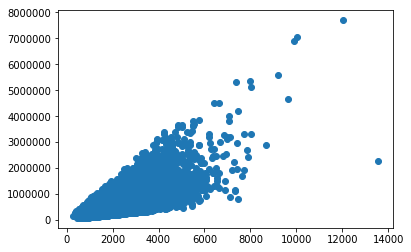

In [2]:
df_data = pd.read_csv("kc_house_data.csv")

x_data = df_data['sqft_living'].values.reshape(-1, 1).astype(np.float32)
y_data = df_data["price"].values.reshape(-1, 1).astype(np.float32)

plt.scatter(x_data, y_data);

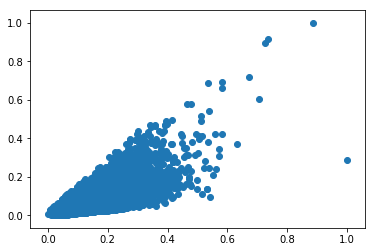

In [3]:
# minmax scaler
minmax_scaler = MinMaxScaler()

x_data = minmax_scaler.fit_transform(x_data)
y_data = minmax_scaler.fit_transform(y_data)

plt.scatter(x_data, y_data);

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [5]:
params = {
    'batch_size': 32,
    'num_workers': 8
}

# Generators
training_set = data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
training_generator = data.DataLoader(training_set, shuffle=True, **params)

validation_set = data.TensorDataset(torch.from_numpy(x_validation), torch.from_numpy(y_validation))
validation_generator = data.DataLoader(validation_set, shuffle=False, **params)

test_set = data.TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))
test_generator = data.DataLoader(test_set, shuffle=False, **params)

In [6]:
from livelossplot import PlotLosses

class LinearRegression(nn.Module):
    def __init__(self, x_dim, y_dim):
        super(LinearRegression, self).__init__()
        self.i2o = nn.Linear(x_dim, y_dim, bias=True)
        self.loss = nn.MSELoss()
        
        
    def forward(self, x):
        return self.i2o(x)
    
    
    def train_(self, generator, epochs, lr=0.01, step=2, device="cpu"):
        self = self.to(device)
        self.optim = torch.optim.SGD(self.parameters(), lr=lr)
        liveloss = PlotLosses()

        for epoch in range(epochs):
            if epoch % step == 0:
                logs = {}
                for phase in ["train", "eval"]:
                    self.train() if phase == 'train' else self.eval()
                    runnging_loss = 0.0
                    
                    for x_data, y_data in generator[phase]:
                        x_data, y_data = x_data.to(device), y_data.to(device)
                        y_pred = self.forward(x_data)
                        loss = self.loss(y_pred, y_data)

                        if phase == "train":
                            self.optim.zero_grad()
                            loss.backward()
                            self.optim.step()
                            
                        runnging_loss += loss.item()

                    logs[phase + "loss"] = runnging_loss
                    
                liveloss.update(logs)
                liveloss.draw()

            else:
                self.train()
                for x_data, y_data in generator["train"]:
                    x_data, y_data = x_data.to(device), y_data.to(device)
                    y_pred = self.forward(x_data)
                    loss = self.loss(y_pred, y_data)

                    self.optim.zero_grad()
                    loss.backward()
                    self.optim.step()
                        
                    
    def test(self, test_generator, device):
            self.eval()
            loss = 0
            with torch.no_grad():
                for x_data, y_data in test_generator:
                    x_data, y_data = x_data.to(device), y_data.to(device)
                    y_pred = self.forward(x_data)
                    loss += (y_pred - y_data)**2
            
            size = len(generator[phase].dataset)
            print('Test Accuracy of the model on the {} test data: {} %'.format(size, loss))
            
        

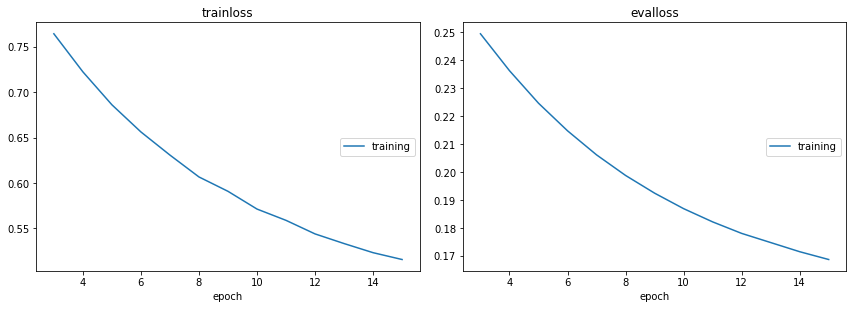

trainloss:
training   (min:    0.516, max:    1.166, cur:    0.516)

evalloss:
training   (min:    0.169, max:    0.283, cur:    0.169)


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

params_model = {
    "x_dim": 1,
    "y_dim": 1
}

params_train = {
    "generator": {
        "train": training_generator,
        "eval": validation_generator
    },
    "epochs": 30,
    "lr": 0.01,
    "step": 2,
    "device": device
}


linear_regression = LinearRegression(**params_model)

linear_regression.train_(**params_train)

In [ ]:
loss = torch.nn.MSELoss()
d = torch.tensor([1,2,3]).float()
dd = torch.tensor([2,4,6]).float()
l = loss(d, dd)

In [ ]:
l

In [ ]:
l.item(b)

In [ ]:
            for epoch in range(epochs):
                is_mod_zero = epoch % 50 == 0
                for phase in ["train", "test"]:
                    if phase == "train" or is_mod_zero:
                        
                        for x_data, y_data in generator[phase]:
                            x_data, y_data = x_data.cuda(), y_data.cuda()
                            y_pred = self.forward(x_data)
                            loss = self.loss(y_pred, y_data)

                            if phase == "train":
                                self.optim.zero_grad()
                                loss.backward()
                                self.optim.step()

                            if is_mod_zero:
                                _, preds = torch.max(y_pred, 1)
                                runnging_acc += torch.sum(preds == y_data)
                                runnging_loss += loss.detached()
                        logs[phase+"acc"] = runnging_acc
                        logs[phase+"loss"] = runnging_loss
                                
                    elif is_mod_zero_mod:
                        for x_data, y_data in generator[phase]:
                            x_data, y_data = x_data.cuda(), y_data.cuda()
                            y_pred = self.forward(x_data)
                            loss = self.loss(y_pred, y_data)

                            _, preds = torch.max(y_pred, 1)
                            runnging_acc += torch.sum(preds == y_data)
                            runnging_loss += loss.detached()
                    
                if is_mod_zero:
                    logs[phase+"acc"] = runnging_acc
                    logs[phase+"loss"] = runnging_loss
                    runnging_acc = 0
                    runnging_loss = 0
                    
                    for x_data, y_data in generator[phase]:
                        x_data, y_data = x_data.cuda(), y_data.cuda()
                        y_pred = self.forward(x_data)
                        loss = self.loss(y_pred, y_data)
                        
                        _, preds = torch.max(y_pred, 1)
                        runnging_acc += torch.sum(preds == y_data)
                        runnging_loss += loss.detach()
                    
                    logs[phase+"acc"] = runnging_acc
                    logs[phase+"loss"] = runnging_loss
                    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))